https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [ ]:
!pip install tensorflow

In [ ]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
import pathlib
from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


In [ ]:
# Downloading the mini_speech_commands dataset from the external URL
data = tf.keras.utils.get_file(
'mini_speech_commands.zip',
origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
extract=True,
cache_dir='.', cache_subdir='data')


182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


# about wget:
Wget is the non-interactive network downloader which is used to download files from the server even when the user has not logged on to the system and it can work in the background without hindering the current process.

In [ ]:
!wget https://www.google.com/imgres?q=images&imgurl=https%3A%2F%2Fnext-images.123rf.com%2Findex%2F_next%2Fimage%2F%3Furl%3Dhttps%3A%2F%2Fassets-cdn.123rf.com%2Findex%2Fstatic%2Fassets%2Ftop-section-bg.jpeg%26w%3D3840%26q%3D75&imgrefurl=https%3A%2F%2Fwww.123rf.com%2F&docid=uT_3T5CYcMSvLM&tbnid=nqZ8izo17eo08M&vet=12ahUKEwiww7j_mr2KAxWA1TgGHeyFCPIQM3oECEIQAA..i&w=3840&h=2628&hcb=2&ved=2ahUKEwiww7j_mr2KAxWA1TgGHeyFCPIQM3oECEIQAA

--2024-12-26 06:42:24--  https://www.google.com/imgres?q=images
Resolving www.google.com (www.google.com)... 142.251.12.106, 142.251.12.147, 142.251.12.99, ...
Connecting to www.google.com (www.google.com)|142.251.12.106|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.google.com/imghp [following]
--2024-12-26 06:42:24--  https://www.google.com/imghp
Reusing existing connection to www.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘imgres?q=images’

imgres?q=images         [ <=>                ]  17.39K  --.-KB/s    in 0s      

2024-12-26 06:42:26 (62.3 MB/s) - ‘imgres?q=images’ saved [17804]



In [ ]:
os.listdir('./data/') #to show what all the data contains


['mini_speech_commands.zip', 'mini_speech_commands', '__MACOSX']

In [ ]:
# Using audio_dataset_from_directory function to create dataset with audio data
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory(
	directory='./data/mini_speech_commands',
	batch_size=16,
	validation_split=0.2,
	output_sequence_length=16000,
	seed=0,
	subset='both')

# Extracting audio labels
label_names = np.array(training_set.class_names)
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


# TensorFlow squeeze -
## Use tf.squeeze to remove a dimension from Tensor in order to transfer a 1-D Tensor to a Vector

In [ ]:
# Defining the squeeze function
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Applying the function on the dataset obtained from previous step
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)


In [ ]:
# Visualize the waveform
audio, label = next(iter(training_set))
display.display(display.Audio(audio[0], rate=16000))


we will convert the audio to a spectrogram and visualize it:

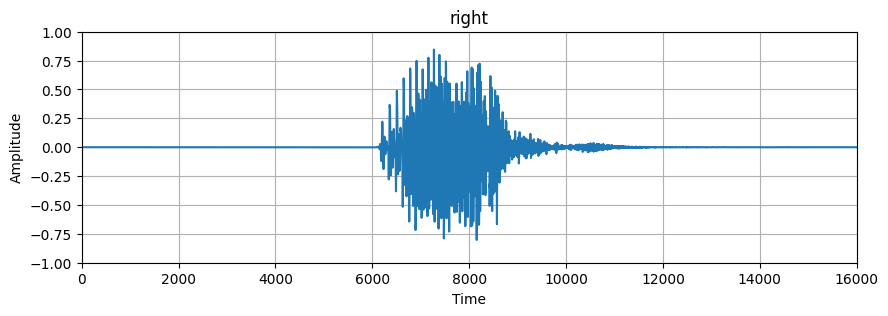

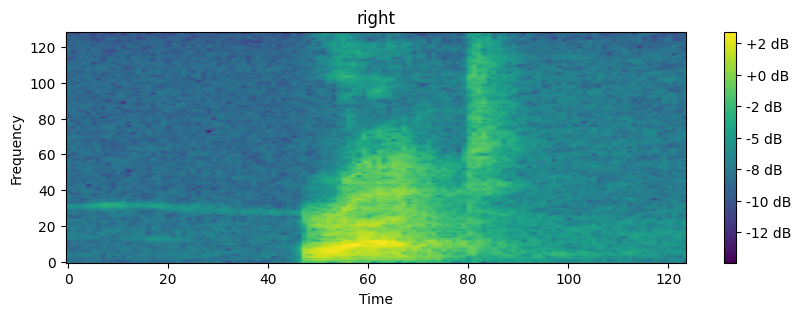

In [ ]:
# Plot the waveform
def plot_wave(waveform, label):
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.plot(waveform)
	plt.xlim([0, 16000])
	plt.ylim([-1, 1])
	plt.xlabel('Time')
	plt.ylabel('Amplitude')
	plt.grid(True)

# Convert waveform to spectrogram
def get_spectrogram(waveform):
	spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) #u can also use librosa instead of stft
	spectrogram = tf.abs(spectrogram)
	return spectrogram[..., tf.newaxis]

# Plot the spectrogram
def plot_spectrogram(spectrogram, label):
	spectrogram = np.squeeze(spectrogram, axis=-1)
	log_spec = np.log(spectrogram.T + np.finfo(float).eps) #finfo is a function that provides information about the machine limits and floating-point data types
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.imshow(log_spec, aspect='auto', origin='lower')
	plt.colorbar(format='%+2.0f dB')
	plt.xlabel('Time')
	plt.ylabel('Frequency')

# Plotting the waveform and the spectrogram of a random sample
audio, label = next(iter(training_set))

# Plot the wave with its label name
plot_wave(audio[0], label_names[label[0]])

# Plot the spectrogram with its label name
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])


In [ ]:
# Creating spectrogram dataset from waveform or audio data
def get_spectrogram_dataset(dataset):
	dataset = dataset.map(
		lambda x, y: (get_spectrogram(x), y),
		num_parallel_calls=tf.data.AUTOTUNE)
	return dataset

# Applying the function on the audio dataset
train_set = get_spectrogram_dataset(training_set)
validation_set = get_spectrogram_dataset(validation_set)

# Dividing validation set into two equal val and test set
val_set = validation_set.take(validation_set.cardinality() // 2)
test_set = validation_set.skip(validation_set.cardinality() // 2)


In [ ]:
#Check the dimension of the input dataset
train_set_shape = train_set.element_spec[0].shape
val_set_shape = val_set.element_spec[0].shape
test_set_shape = test_set.element_spec[0].shape

print("Train set shape:", train_set_shape)
print("Validation set shape:", val_set_shape)
print("Testing set shape:", test_set_shape)


Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


In [ ]:
# Defining the model
def get_model(input_shape, num_labels):
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape),
		# Resizing the input to a square image of size 64 x 64 and normalizing it
		tf.keras.layers.Resizing(64, 64),
		tf.keras.layers.Normalization(),

		# Convolution layers followed by MaxPooling layer
		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.Conv2D(128, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Flatten(),

		# Dense layer
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),

		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	# Printing model summary
	model.summary()
	return model

# Getting input shape from the sample audio and number of classes
input_shape = next(iter(train_set))[0][0].shape
print("Input shape:", input_shape)
num_labels = len(label_names)

# Creating a model
model = get_model(input_shape, num_labels)


Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,568,011 (112.79 MB)

 Trainable params: 29,568,008 (112.79 MB)

 Non-trainable params: 3 (16.00 B)

multiclass allnkil binary anny upyogikunne
accuracy-increase
loss-release

In [ ]:
model.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.3884 - loss: 1.7107 - val_accuracy: 0.7763 - val_loss: 0.7758
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.7371 - loss: 0.8057 - val_accuracy: 0.8163 - val_loss: 0.5523
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8216 - loss: 0.5517 - val_accuracy: 0.8475 - val_loss: 0.4703
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8666 - loss: 0.4084 - val_accuracy: 0.8600 - val_loss: 0.4422
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8840 - loss: 0.3477 - val_accuracy: 0.8750 - val_loss: 0.4251
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9144 - loss: 0.2694 - val_accuracy: 0.8650 - val_loss: 0.4389
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9181 - loss: 0.2417 - val_accuracy: 0.8775 - val_loss: 0.4569
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9308 - loss: 0.2169 - val_ac

Text(0, 0.5, 'Accuracy')

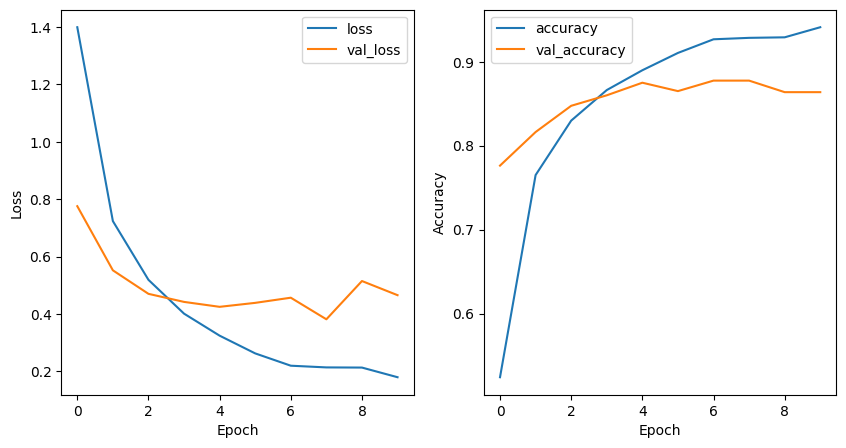

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


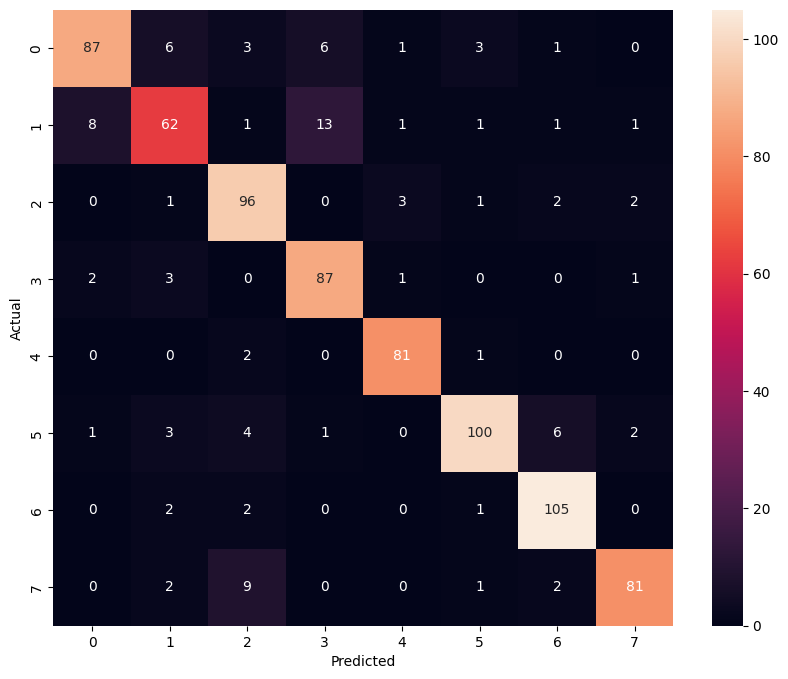

In [ ]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_set), axis=1)
y_true = np.concatenate([y for x, y in test_set], axis=0)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.89      0.81      0.85       107
           1       0.78      0.70      0.74        88
           2       0.82      0.91      0.86       105
           3       0.81      0.93      0.87        94
           4       0.93      0.96      0.95        84
           5       0.93      0.85      0.89       117
           6       0.90      0.95      0.93       110
           7       0.93      0.85      0.89        95

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.88      0.87      0.87       800



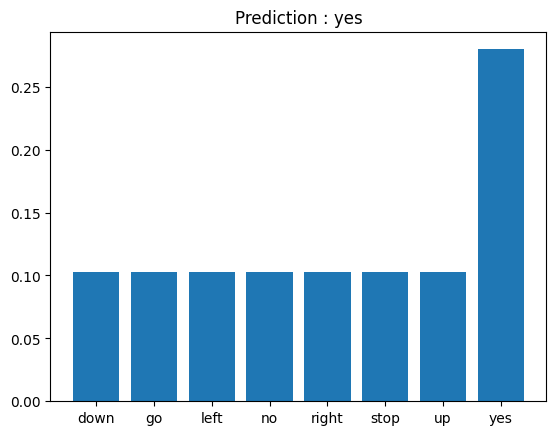

In [ ]:
path = 'data/mini_speech_commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'yes')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()


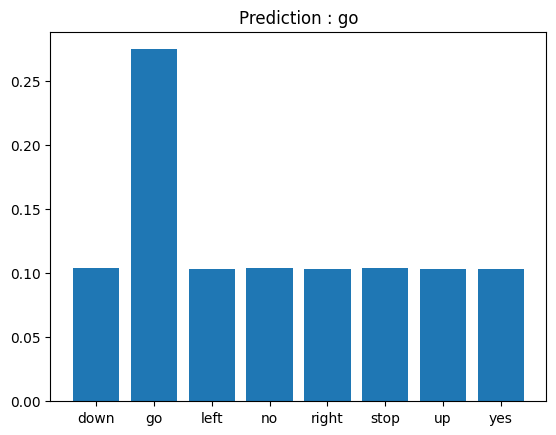

In [ ]:
path = 'data/mini_speech_commands/go/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'go')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()


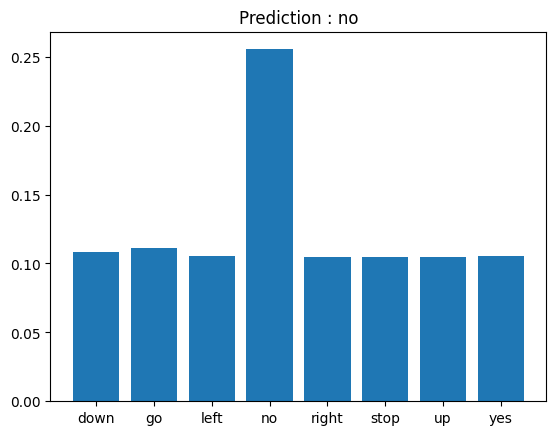

In [ ]:
path = 'data/mini_speech_commands/down/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'down')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()
